In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
eps_0 = 8.8542e-1 #x10^-13 C/(V*cm)
eps_r_1 = 1
eps_r_2 = 2
rho_1 = 1 #x10^-13 C/(cm^3)
rho_2 = 0
phi_1 = 1.5
phi_2 = 0
L = 0.01

In [3]:
mesh = np.linspace(0, 2*L, 121)

In [4]:
def eps(x):
    return (eps_r_1 if (x < L) else eps_r_2)*eps_0

def rho(x):
    return rho_1 if (x < L) else rho_2

In [5]:
A = np.zeros((121,121))
b = np.zeros((121,1))

for i in range(0,121):
    if (i == 0 or i == 120):
        continue
    else:
        b[i] = (integrate.quad(lambda x: (x - mesh[i-1])*rho(x), mesh[i-1], mesh[i])[0] + integrate.quad(lambda x: (mesh[i+1] - x)*rho(x), mesh[i], mesh[i+1])[0]) 
    for j in range(0,121):
        if (j < i-1 or j > i+1):
            continue
        if (i == 0 or i == 120):
            continue
        
        if (j < i):
            A[i][j] = integrate.quad(lambda x: -1 * eps(x), mesh[j], mesh[j+1])[0] 
        elif (j > i):
            A[i][j] = integrate.quad(lambda x: -1 * eps(x), mesh[j-1], mesh[j])[0] 
        else:
            A[i][j] = (integrate.quad(eps, mesh[j-1], mesh[j])[0] + integrate.quad(eps, mesh[j], mesh[j+1])[0])
            
A[0][0] = 1; A[0][1:] = 0
A[-1][-1] = 1; A[-1][:-1] = 0

b[0] = phi_1; b[-1] = phi_2

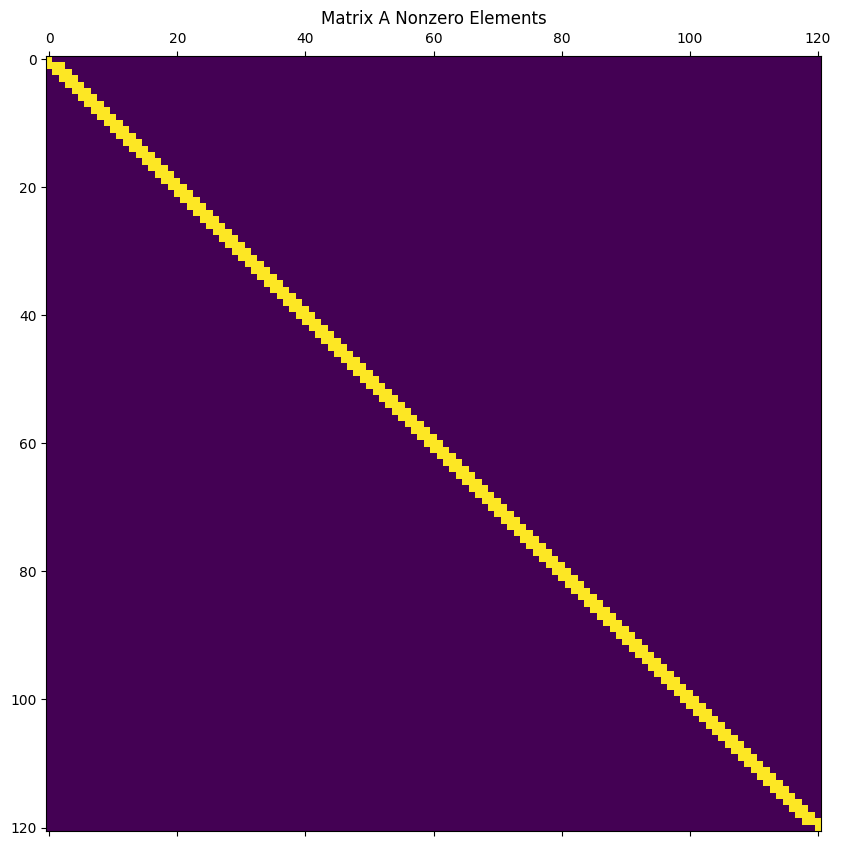

In [6]:
fig = plt.figure(figsize=(10,10))
plt.matshow(np.ma.make_mask(A), fig.number)
plt.title("Matrix A Nonzero Elements")
plt.show()

In [7]:
phi = np.linalg.solve(A, b)

In [8]:
def dL(x):
    idx_1 = np.where(mesh <= x)[0][-1]
    idx_2 = np.where(mesh >= x)[0][0]
    
    if (idx_1 == idx_2):
        if (idx_1 == mesh.size -1):
            idx_1 -= 1
        else:
            idx_2 += 1
            
    x_1 = mesh[idx_1]
    x_2 = mesh[idx_2]
    
    return (x_2 - x_1, x_2, x_1, idx_2, idx_1)

In [9]:
def phi_x(x):    
    L, x_2, x_1, idx_2, idx_1 = dL(x)
    
    x = np.array([x_2 - x, x - x_1]).reshape((1,2))
    p = np.array([phi[idx_1], phi[idx_2]]).reshape((2,1))
    
    return 1/L * np.matmul(x,p)  

p = np.array([phi_x(x) for x in mesh]).reshape(-1,)

In [10]:
def E_x(x):
    L, _, _, idx_2, idx_1 = dL(x)
    
    x = np.array([-1, 1]).reshape((1,2))
    p = np.array([phi[idx_1], phi[idx_2]]).reshape((2,1))
    
    return 1/L * np.matmul(x,p)

E = np.array([E_x(x) for x in mesh]).reshape(-1,)

In [11]:
def D_x(x):
    L, _, _, _, _ = dL(x)
    
    return eps(x) * np.abs(E_x(x)) * 1e-13 * 100

D = np.array([D_x(x) for x in mesh]).reshape(-1,)

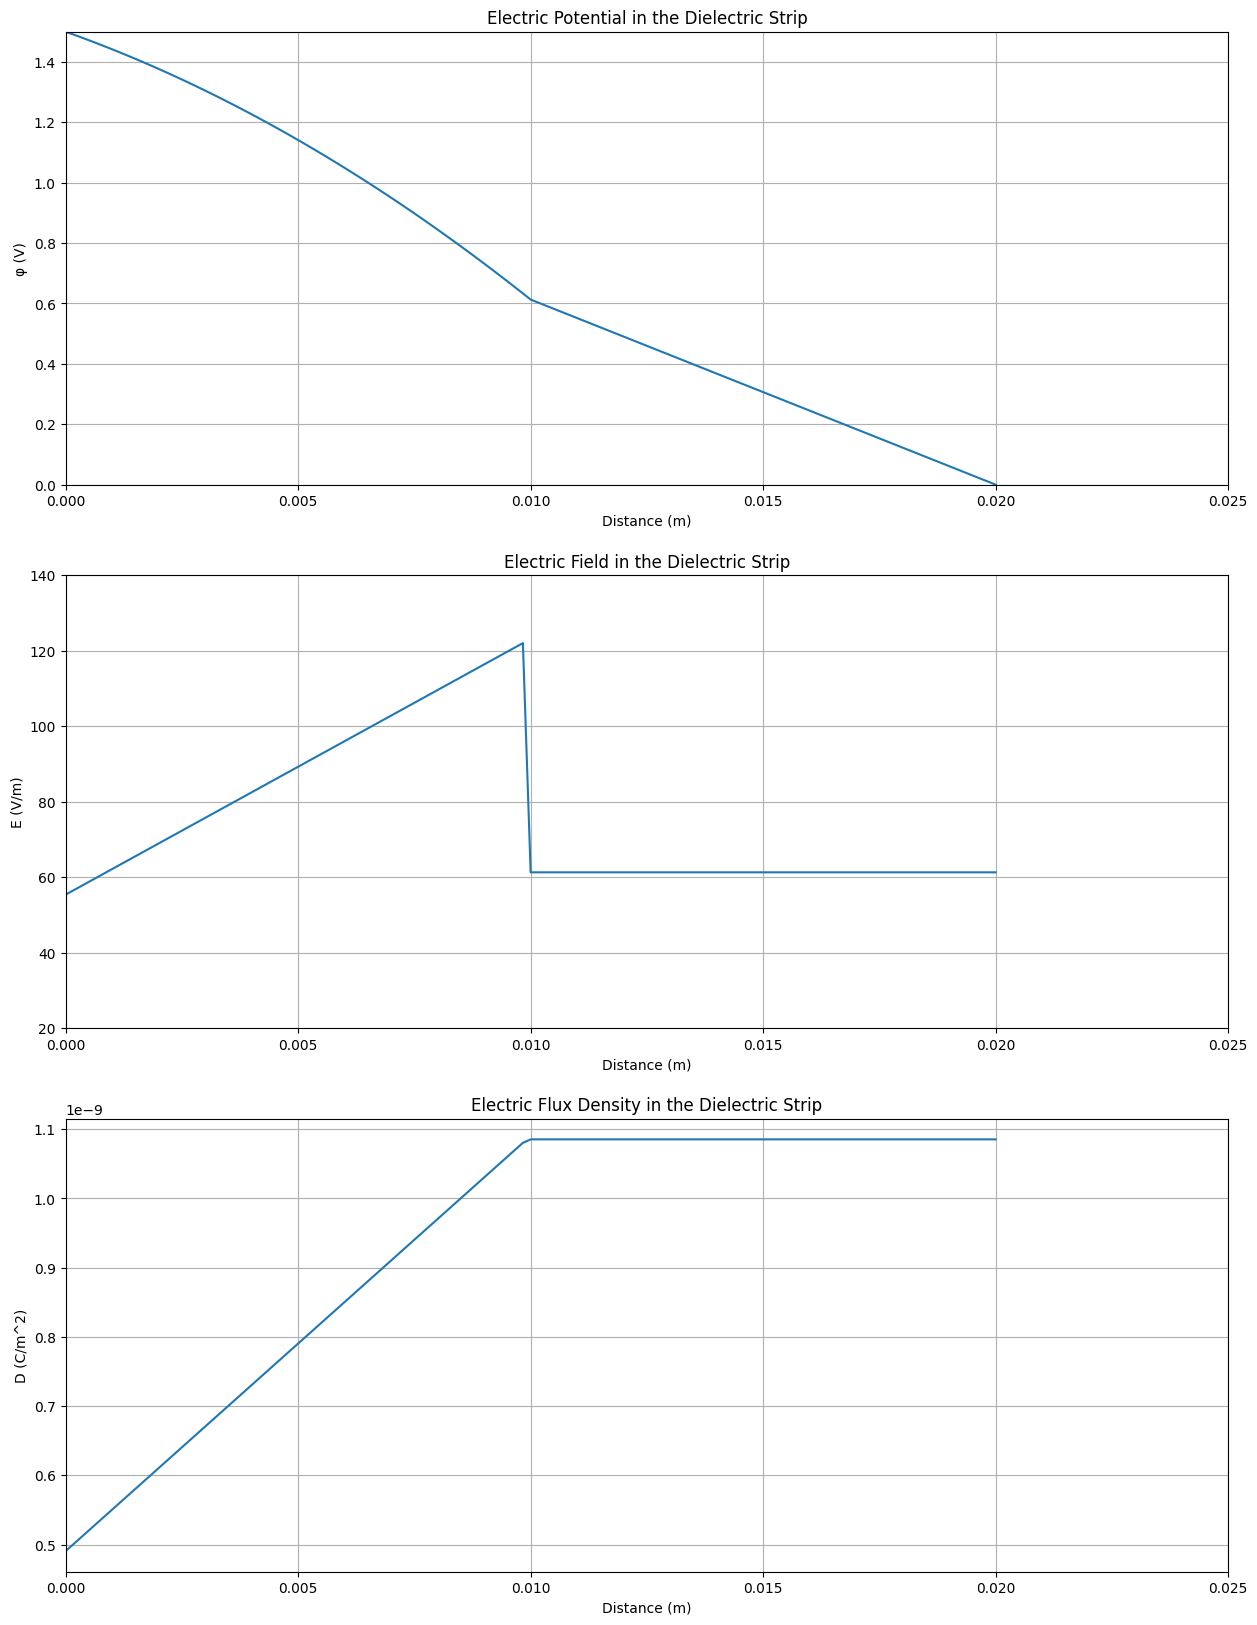

In [12]:
fix, ax = plt.subplots(3, 1, figsize=(15,20))

# Plot the potential
ax[0].plot(mesh, phi)
ax[0].set_title("Electric Potential in the Dielectric Strip")
ax[0].set_xlabel("Distance (m)")
ax[0].set_ylabel("\u03C6 (V)")
ax[0].set_xlim([0, 0.025])
ax[0].set_ylim([0, 1.5])
ax[0].grid()

# Plot the electric field
ax[1].plot(mesh, np.abs(E))
ax[1].set_title("Electric Field in the Dielectric Strip")
ax[1].set_xlabel("Distance (m)")
ax[1].set_ylabel("E (V/m)")
ax[1].set_xlim([0, 0.025])
ax[1].set_ylim([20, 140])
ax[1].grid()

# Plot the electric flux density
ax[2].plot(mesh, np.abs(D))
ax[2].set_title("Electric Flux Density in the Dielectric Strip")
ax[2].set_xlabel("Distance (m)")
ax[2].set_ylabel("D (C/m^2)")
ax[2].set_xlim([0, 0.025])
#ax[2].set_ylim([0, 14])
ax[2].grid()

plt.show()